# Tutorial 3: Geometric Deep Learning with PyTorch

Contact: [Andrej Janchevski](mailto:andrej.janchevski@epfl.ch)

## Setup

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

2.0.1
Looking in links: https://data.pyg.org/whl/torch-2.0.1.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.1-cp39-cp39-macosx_10_9_x86_64.whl size=294080 sha256=f11f52c0c6fb1a62488d94ce81fee1dc6506e61c5b974e6a142f83355903c82a
  Stored in directory: /Users/xuyixuan/Library/Caches/pip/wheels/d5/0c/18/11b4cf31446c5d460543b0fff930fcac3a3f8a785e5c73fb15
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.0.1.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.17-cp39-cp39-macosx_10_9_x86_64.whl size=482085 sha256=bca9e41d21ba713c6d020aa3ffdccbb7eb4f4804bbfbcfda8c887667fe775235
  Stored in directory: /Users/xuyixuan/Library/Caches/pip/wheels/f8/43/54/bcb8acdd1109bd1e4c71106

In [1]:
from typing import List

import networkx as nx
import numpy as np
import torch
import torchmetrics
from torch import nn
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

To activate a GPU in colab , open the *Runtime* drop-down menu and click *Change runtime type*, then choose GPU as hardware accelerator.

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cpu'

## Part 1: PyTorch

[PyTorch](https://pytorch.org/) is a open source machine learning framework.

Is is based on tensor manipulation and automatic differentiation.

### Tensor manipulation

Torch tensors can be manipulated just like numpy arrays, and they support all algebraic manipulations.

In [ ]:
a = torch.tensor(
    [[1, 0],
     [0, 2]]
)

b = torch.tensor(
    [[0, 3],
     [4, 0]]
)

################################################################################

print("a + b:")
print(a + b)

print("a * b")
print(a * b)

print("a @ b")
print(a @ b)

print("2.5 * a")
print(2.5 * a)

print("1 + a")
print(1 + a)

a + b:
tensor([[1, 3],
        [4, 2]])
a * b
tensor([[0, 0],
        [0, 0]])
a @ b
tensor([[0, 3],
        [8, 0]])
2.5 * a
tensor([[2.5000, 0.0000],
        [0.0000, 5.0000]])
1 + a
tensor([[2, 1],
        [1, 3]])


### PyTorch modules

Neural networks are defined in PyTorch through [`Modules`](https://pytorch.org/docs/stable/notes/modules.html), which implement `forward` and `backward` methods.
The `forward` methods takes batches of inputs and performs some differentiable manipulation.
The backward pass compute the gradient of `forward` by automatic differentiation.

The `torch.nn` module provides many popular neural network layers, which can be composed out of the box. You can have a look at the [documentation](https://pytorch.org/docs/stable/nn.html) for a complete list of available layers.

In [ ]:
# Let's generate a random design matrix
X = torch.empty(5, 10).normal_()
X

tensor([[ 0.5913,  0.0474, -1.1537,  0.6256,  0.5240, -1.5557,  0.6760, -1.9162,
         -1.7580,  0.6008],
        [ 0.6268, -0.6734,  0.3466,  0.7091, -0.6047, -0.7825, -0.6235, -0.8952,
          0.6586, -0.6758],
        [-1.1207, -0.5124, -0.5364, -0.2380,  1.0221,  1.1629,  0.7975,  0.6220,
         -1.5485, -0.3435],
        [-0.3868,  0.8544,  1.4323,  0.1108,  0.7727, -2.0348,  3.0401,  0.5301,
         -0.5793, -1.6304],
        [-0.1099,  0.9851, -2.4994, -1.0099,  0.8438,  0.0306,  0.6683, -0.3880,
         -1.2757, -1.7362]])

In [ ]:
# Let's apply a Linear (fully connected) layer
linear = nn.Linear(
    in_features=10,
    out_features=2,
)

out = linear(X)
out

tensor([[-0.5391,  0.0801],
        [-0.0693,  0.0740],
        [ 0.7561,  0.2732],
        [ 0.6032,  0.0743],
        [ 0.7280,  0.9628]], grad_fn=<AddmmBackward0>)

We can define custom modules by inheriting from the `toch.nn.Module` base class and defining the `forward` method.

In [ ]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, input):
        return (input @ self.weight) + self.bias

In [ ]:
my_linear = MyLinear(10, 2)
my_linear(X)

tensor([[-10.2212,   4.0541],
        [ -5.3334,   0.5416],
        [  2.0084,  -1.9742],
        [ -4.3465,   2.3677],
        [ -1.5075,   0.4445]], grad_fn=<AddBackward0>)

### Neural networks

Feedforward neural networks are, to simplify, a stack of layers which maps from input to output.

In [ ]:
mlp = nn.Sequential(
    nn.Linear(10,20),
    nn.ReLU(),
    nn.Linear(20, 2),
    nn.Softmax(dim=-1),
)

In [ ]:
mlp(X)

tensor([[0.5938, 0.4062],
        [0.4163, 0.5837],
        [0.4182, 0.5818],
        [0.4481, 0.5519],
        [0.3973, 0.6027]], grad_fn=<SoftmaxBackward0>)

For more flexibility, we can define NNs as Modules.

In [ ]:
class MLP(nn.Module):
    def __init__(self, nb_in: int, nb_hidden: int, nb_out: int) -> None:
        super().__init__()
        self.l1 = nn.Linear(nb_in, nb_hidden)
        self.l2 = nn.Linear(nb_hidden, nb_hidden)
        self.l3 = nn.Linear(nb_hidden, nb_out)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = torch.relu(self.l1(X))
        X = torch.relu(self.l2(X))
        return torch.softmax(self.l3(X), dim=-1)

In [ ]:
mlp2 = MLP(10, 20, 2)
mlp2

MLP(
  (l1): Linear(in_features=10, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
mlp2(X)

tensor([[0.4793, 0.5207],
        [0.4727, 0.5273],
        [0.4675, 0.5325],
        [0.5030, 0.4970],
        [0.5124, 0.4876]], grad_fn=<SoftmaxBackward0>)

### Using GPUs

All tensors and modules can be moved to GPU using the `.to(...)` method. Pay attention, everything shall be moved to the same "device"!


In [ ]:
X = X.to(device)
mlp.to(device)


# Verify the device of your objects
print(f"X: {X.device}, output: {mlp(X).device}")

X: cuda:0, output: cuda:0


## Part 2: Training neural networks

### Datasets and dataloaders

PyTorch provides utilities to load and batch data. They also have many datasets ready to use.

In [3]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

We use the MNIST dataset for this part of the tutorial. It is readily available in PyTorch, and quickly downloaded on Google's servers 😉

In [ ]:
# We convert images to tensors and normalize them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))] # Mean and std are well known
)
dataset_tr = MNIST(".", transform=transform, train=True, download=True)        
dataset_te = MNIST(".", transform=transform, train=False, download=True)        

# Lets wrap the dataset in a dataloader, to get batched samples
BATCH_SIZE = 64
loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE)
loader_te = DataLoader(dataset_te, batch_size=BATCH_SIZE)

MNIST dataset contains 28x28 grayscale images of handwritten digits, which we would like to identify

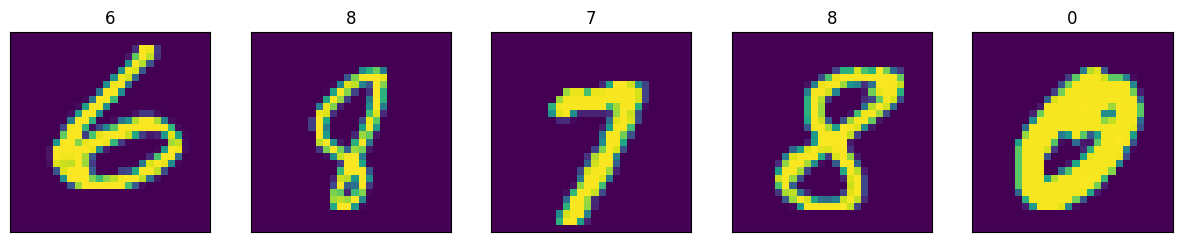

In [ ]:
def plot_random_sample(ax):
    X, y = dataset_tr[torch.randint(len(dataset_tr), (1,)).item()]
    
    ax.imshow(X[0].numpy()*0.3081+0.1307)
    ax.set(title=y)
        
fig, axes = plt.subplots(1,5, figsize=(15,3))
for ax in axes:
    plot_random_sample(ax)
    ax.set(xticks=[], yticks=[])
plt.show()

### Loss functions

PyTorch comes with many loss functions in the `torch.nn` module. For a complete list you can refer to the [doc](https://pytorch.org/docs/stable/nn.html#loss-functions).

For our handwritten-digit classification task a good choice is the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), which takes raw class scores and  compares them to the desired class labels.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

loss_fn(
    torch.tensor(
        [[ 0, 10,  2],
         [11,  6,  5],
         [13, 20,  1],
         [ 2,  7, 15]],
        dtype=torch.float
    ),
     torch.tensor([1, 0, 0, 2])
)

tensor(1.7527)

### Training loop

Neural Networks are trained with Stochastic Gradient Descent (SGD), or variants thereof. One "epoch" of SGD consist in performing sequentially one descent step for each batch in the training dataset.

In [ ]:
# Lets define a feedforward CNN

cnn = nn.Sequential(
    nn.Conv2d(1, 4, 5), # out_size: (4, 24, 24)
    nn.ReLU(),
    nn.Conv2d(4, 16, 5), # out_size: (16, 20, 20)
    nn.ReLU(),
    nn.Conv2d(16, 16, 5), # out_size: (16, 16, 16),
    nn.ReLU(),
    nn.Flatten(), # out_size: (4096),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
).to(device)

# Note that we moved it to GPU!

SGD is an optimization algorithm and PyTorch implements it, along with many others, in the `torch.optim` module (cfr [doc](https://pytorch.org/docs/stable/optim.html)).
Those "optimizers" handle the update of the desired parameters through a `step()` method which they all implement.


In [ ]:
optimizer = torch.optim.SGD(
    params=cnn.parameters(),
    lr=1e-3,
)

In [ ]:
def train_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor
) -> torch.Tensor:
    # Start by resetting the optimizer
    optimizer.zero_grad()

    # Compute the model predictions and their loss
    out = model(X)
    loss = loss_fn(out, y)

    # Compute gradients
    loss.backward()

    # Perform the optimization step
    optimizer.step()

    return loss

Now let's optimize our CNN

In [ ]:
NB_EPOCHS = 5
nb_batches = round(len(dataset_tr) / BATCH_SIZE)
    
for epoch in range(NB_EPOCHS):
    for X, y in tqdm(loader_tr, total=nb_batches, desc=f"Epoch {epoch+1}"):
        X, y = X.to(device), y.to(device)
    
        loss = train_step(cnn, optimizer, loss_fn, X, y)

Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

### Evaluation

Now that the model is trained, we shall check its performances. To compute metrics, we use the [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/) library, which we already installed in the setup.

We are mainly interested in the accuracy of our model, so lets compute it.

In [ ]:
def evaluate(model: nn.Module, metric: torchmetrics.Metric, loader: DataLoader):
    with torch.no_grad():
        for X, y in tqdm(loader, total=len(loader)):
            X, y = X.to(device), y.to(device)
            # Compute probabilities
            preds = model(X).softmax(dim=-1)
    
            # metric on current batch
            _ = metric(preds, y)
        
        # Accumated metric (on all batches)
        return metric.compute()

In [ ]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
acc_tr = evaluate(cnn, accuracy_fn, loader_tr)

accuracy_fn.reset() # Reset the accuracy!
acc_te = evaluate(cnn, accuracy_fn, loader_te)

print(f"Train accuracy: {acc_tr:.2%}")
print(f"Test accuracy:  {acc_te:.2%}")

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train accuracy: 93.39%
Test accuracy:  93.82%


Not bad for a first try! 🎉

## Part 3: PyTorch Geometric

Now that we are acquainted with PyTorch, let's plug in Graph data! 😁

Our framework of choice is [PyTorch Geometric][1], a useful extension of PyTorch designed to work with graphs. This tutorial will be a quick overview of a few main features, and you can complete it by checking out the [documentation][1] and the [official tutorials][2].


[1]: https://pytorch-geometric.readthedocs.io/en/latest/
[2]: https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

### PyG data

A single graph in PyTorch Geometric is described by an instance of `torch_geometric.data.Data`, which can hold several attributes, among which:

* `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

* `data.edge_index`: Graph connectivity tensor with shape `[2, num_edges]` and type `torch.long`. Note that one would expect the **node pairs** to be saved as rows, but in this format they are **saved as columns** of the `edge_index` matrix.

* `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

* `data.y`: Target to train against, e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

Not all of these fields must be present and the user can define his own attributes. The following cell shows an example for the creation of a simple graph in PyTorch Geometric.


In [4]:
import torch_geometric as pyg
from torch_geometric.data import Data

In [5]:
## Create an undirected graph having three nodes (0, 1, 2).
## Nodes 0 and 1 are connected; nodes 1 and 2 are connected (in both directions).
## Each node has a single feature. These features are equal to
## -1, 0, 1 for the three nodes respectively, in this order.
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

As you can see, it is very close to Networkx, and utility functions can map back and forth from one to the other

In [6]:
from torch_geometric.utils import to_networkx, from_networkx

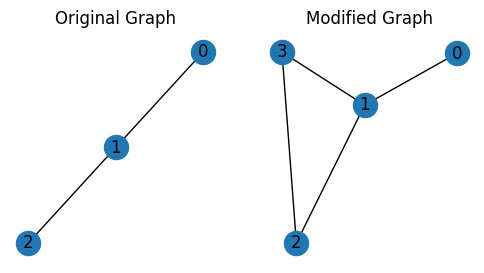

tensor([[0, 1, 1, 1, 2, 2, 3, 3],
        [1, 0, 2, 3, 1, 3, 1, 2]])


In [7]:
Gnx = to_networkx(G1, to_undirected=True)

fig, axes = plt.subplots(1,2, figsize=(6,3))
nx.draw(Gnx, ax=axes[0], with_labels=True)
axes[0].set_title('Original Graph')

Gnx.add_node(3)
Gnx.add_edges_from([(1,3), (2,3)])
nx.draw(Gnx, ax=axes[1], with_labels=True)
axes[1].set_title('Modified Graph')

plt.show()

G2 = from_networkx(Gnx)
print(G2.edge_index)

### PyG Datasets and Dataloaders

PyG implements its own wrappers of `Dataset` and `DataLoader`.
They provide the same interface as regular PyTorch, but instead of Tensors they return instances of `Data`.



PyG comes with some ready-to-use datasets, such as the Karate Club.

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


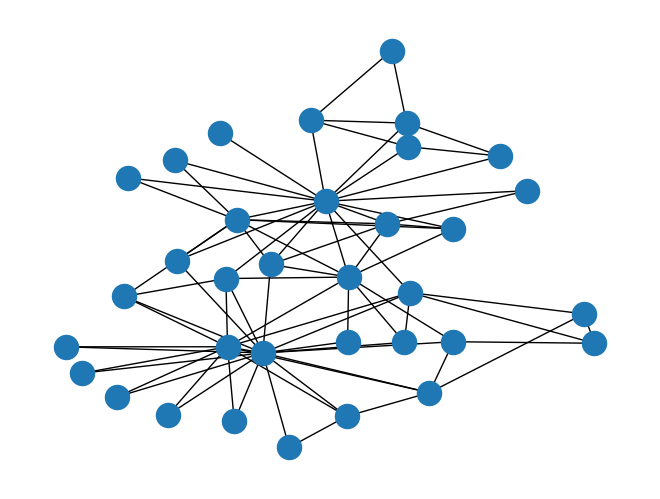

In [8]:
from torch_geometric.datasets import KarateClub

# Load the dataset
dataset = KarateClub()

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Let's draw it
nx.draw_kamada_kawai(to_networkx(dataset[0], to_undirected=True))

Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2


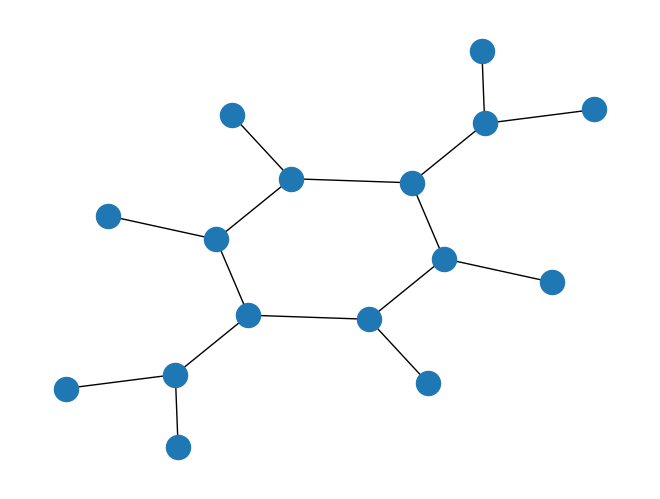

In [9]:
from torch_geometric.datasets import TUDataset

# Load the dataset
dataset = TUDataset(root=".", name="Mutagenicity")

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Let's draw a sample
nx.draw_kamada_kawai(to_networkx(dataset[0], to_undirected=True))

Custom datasets can be defined as well, by inheriting from the `torch_geometric.data.Dataset` class and defining the following methods:

- `torch_geometric.data.Dataset.len()`: Returns the number of examples in your dataset.
- `torch_geometric.data.Dataset.get()`: Implements the logic to load a single graph.



See ["Creating Your Own Datasets"][^1] for more info.

[^1]: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#

In [10]:
class RandomGraphs(pyg.data.Dataset):
    def __init__(self, nb_graphs: int):
        super().__init__()

        self.graph_list = []
        for _ in range(nb_graphs):
            G = nx.erdos_renyi_graph(10, 0.4)
            self.graph_list.append(from_networkx(G))

    def len(self) -> int:
        return len(self.graph_list)
    
    def get(self, index: int) -> Data:
        return self.graph_list[index]

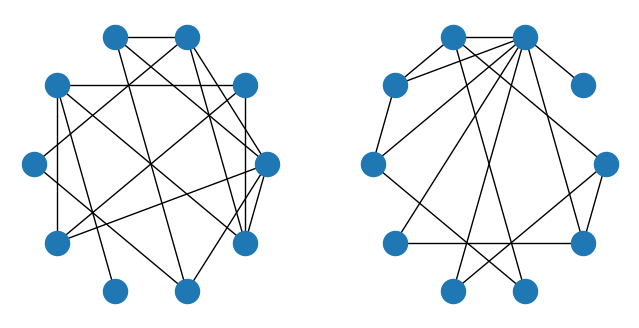

In [11]:
rand_graphs = RandomGraphs(5)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
nx.draw_circular(to_networkx(rand_graphs[0], to_undirected=True), ax=axes[0])
nx.draw_circular(to_networkx(rand_graphs[3], to_undirected=True), ax=axes[1])

For efficiency reasons, a Pytorch Geometric Dataloader builds a batch of graphs by considering it as a unique big graph: the big graph adjacency matrix is built by stacking diagonally the adjacency matrices of the graphs in the batch (which are defined by `edge_index`); features and target matrices are concatenated in the node dimension. This composition allows differing number of nodes and edges over examples in one batch.

$$  A =
  \begin{bmatrix}
    A_{1} & & \\
    & \ddots & \\
    & & A_{N}
  \end{bmatrix}, \quad X = \begin{bmatrix}
X_1\\ 
\vdots \\ 
X_N
\end{bmatrix}, \quad Y = \begin{bmatrix}
Y_1\\ 
\vdots\\
Y_N
\end{bmatrix}$$

A batch of graphs will contain the `batch` attribute, which is a tensor whose length is equal to the number of nodes in the big graph obtained by the union of all the graphs in the batch. Such tensor maps each node to the index of the graph that nodes originally came from. Thus, this allows for recovering the original graphs from a batch coming form the dataloader.

Luckily, you will not have to handle this, but it is good to understand it nonetheless.
This batching strategy allows us to learn local models on huge graphs just by looking at $n$-hop neighborhoods, instead of loading all data, for instance.


In [12]:
# Split dataset in train and test
split_idx = round(len(dataset) * 0.7)
dataset_tr = dataset[:split_idx]
dataset_te = dataset[split_idx:]

BATCH_SIZE = 16
loader_tr = pyg.loader.DataLoader(dataset_tr, batch_size=BATCH_SIZE, shuffle=True)
loader_te = pyg.loader.DataLoader(dataset_te, batch_size=BATCH_SIZE)

In [22]:
len(dataset_tr) / len(loader_tr)

15.978947368421053

In [13]:
data_batch = next(iter(loader_tr))
print(data_batch)
print("Number of graphs in the batch:",data_batch.num_graphs)

DataBatch(edge_index=[2, 938], x=[461, 14], edge_attr=[938, 3], y=[16], batch=[461], ptr=[17])
Number of graphs in the batch: 16


This output indicates that the batch contains a total of 16 graphs. Each graph in the batch is represented by the following attributes:

* edge_index: a tensor of shape (2, num_edges), which represents the indices of the nodes that are connected by each edge in the graph.
* x: a tensor of shape (num_nodes, num_node_features), which represents the node features for each node in the graph.
* edge_attr: a tensor of shape (num_edges, num_edge_features), which represents the edge features for each edge in the graph.
* y: a tensor of shape (num_graphs,), which represents the target variable (e.g., the class label) for each graph in the batch.
* batch: a tensor of shape (num_nodes,), which assigns each node to its corresponding graph in the batch.
* ptr: a tensor of shape (num_graphs + 1,), which provides pointers to the starting and ending indices of the nodes and edges for each graph in the batch.

### Graph Neural Networks

Graph Neural Networks can be implemented just like regular Neural Network in PyTorch, i.e. as `nn.Module`s. One should be careful to include, in the forward pass, all arguments required by the Graph layers. Generally those are the `edge_index` and the `batch` attributes of data, on top of the features.


In [23]:
def gnn_evaluate(gnn: nn.Module, metrics: List[torchmetrics.Metric], loader: DataLoader):
    with torch.no_grad():
        gnn.eval()
        for batch in tqdm(loader, total=len(loader)):
            batch.to(device)
            # Compute probabilities
            preds = gnn(batch.x, batch.edge_index, batch.batch).softmax(dim=-1)
    
            # metric on current batch
            for metric in metrics:
                _ = metric(preds, batch.y)
        
        # Accumated metric (on all batches)
        return metrics

In [24]:
class GNN(nn.Module):
    def __init__(self, num_node_features: int, num_classes: int):
        super().__init__()

        self.conv1 = pyg.nn.GraphConv(num_node_features, 64)
        self.conv2 = pyg.nn.GraphConv(64, 64)
        self.conv3 = pyg.nn.GraphConv(64, 128)
        self.conv4 = pyg.nn.GraphConv(128, 128)
        self.conv5 = pyg.nn.GraphConv(128, 256)

        self.linear1 = nn.Linear(256, num_classes)
    
    def forward(self, x, edge_index, batch= None):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()

        x = pyg.nn.global_add_pool(x, batch)
        return self.linear1(x)

In [25]:
gnn = GNN(
    num_node_features=dataset.num_node_features,
    num_classes = 2,
).to(device)

optimizer = torch.optim.SGD(gnn.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss().to(device)

In [26]:
NB_EPOCHS = 15

for epoch in range(NB_EPOCHS):
    for batch in tqdm(loader_tr, desc=f"Epoch {epoch+1}"):
        batch.to(device)
    
        out = gnn(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/190 [00:00<?, ?it/s]

In [27]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
confusion_fn = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=2).to(device)

metrics = [accuracy_fn, confusion_fn]

gnn_evaluate(gnn, metrics, loader_tr)
acc_tr = accuracy_fn.compute()
conf_tr = confusion_fn.compute().cpu().numpy()

# Reset the metrics!
for metric in metrics:
    metric.reset()

gnn_evaluate(gnn, metrics, loader_te)
acc_te = accuracy_fn.compute()
conf_te = confusion_fn.compute().cpu().numpy()

print(f"Train accuracy: {acc_tr:.2%}")
print(conf_tr)
print(f"Test accuracy:  {acc_te:.2%}")
print(conf_te)

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Train accuracy: 74.60%
[[1494  183]
 [ 588  771]]
Test accuracy:  73.79%
[[640  84]
 [257 320]]


Again, pretty cool results! 🥳

## Part 4: Splitting graph data

In the previous sections, we encontered training and test data, without explaining what they are, or how we obtain them.

### Definitions

- **Train data**: is the set of samples that we use during training. The model tries to learn the objective function by observing them and thus learns parameters $\mathbf{\Theta^*}$ that mininimize the loss function $f(\mathcal{D}_{tr}, \mathbf{\Theta^*})$.
- **Test data**: is an independent dataset $\mathcal{D}_{te}$ which is never seen during training. We use it to estimate the *expected performance* of the trained model (i.e. the average performance on real world data).
- **Validation data**: it is again an independent set of samples. It is used to select *hyperparameters*, i.e. parts of the models that are not optimized with gradient descent. Sometimes it is replaced by *cross-validation*.

It is extremely important to always use a *virgin test dataset* to report performances of your models, which is why an independent validation dataset shall be used for model selection.

Generally, when we are provided a dataset, we obtain these splits with a random partition. Based on the amount of data, we choose how much to use for each split. A common option is to use 30% for test, 20% for validation, and 50% for train.

### Network data

When working with network data, the extraction of the three splits depends on the kind of task that we want to solve.

#### Node-level tasks

For node-level tasks, each node is a sample, and often they come from a single graph.
In this case, we obtain the splits using non-overlapping **masks**.


In [29]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print("Nb samples:", len(dataset))

data = dataset[0].to(device)
print("Nb nodes:", data.num_nodes)

Nb samples: 1
Nb nodes: 34


In [33]:
# Create a random number generator
from numpy.random import default_rng

rng = default_rng(seed=2106)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[:10] = True
rng.shuffle(train_mask)

# The test mask should be the negation of the train mask
test_mask = ~train_mask

# Verify that train and test are disjoint
np.all(test_mask != train_mask)

True

`rng = default_rng(seed=2106)` initializes a new instance of the default NumPy random number generator with a specific seed value of 2106. This allows for reproducibility of random number generation, meaning that if the same seed value is used again in the future, the same sequence of random numbers will be generated.

In [30]:
np.zeros(data.num_nodes, dtype=bool)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [ ]:
# In training we compute the loss only on the training data
train_mask = torch.tensor(train_mask, device=device).bool()
model = pyg.nn.GCNConv(34, 4).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

out = model(data.x, data.edge_index)  # Perform a single forward pass.
loss = loss_fn(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
out.size(), out[train_mask].size(), data.y[train_mask].size()

(torch.Size([34, 4]), torch.Size([10, 4]), torch.Size([10]))

> **Attention!** Shuffling masks can make them overlap. Always define the test mask as the opposite of the train mask. The validation mask should be extracted from the train.


#### Graph-level tasks

In this case samples are single graphs and thus we can easily partiotion the dataset by randomly assigning graphs to each split.

In [31]:
# Load the dataset
dataset = TUDataset(
    root=".", name="Mutagenicity",
)

In [35]:
len(dataset)

4337

In [34]:
# shuffle 
indices = np.arange(len(dataset))
rng.shuffle(indices)
dataset = dataset[indices]

# Split
train_end_idx = int(0.5 * len(dataset))
val_end_idx = int(0.7 * len(dataset))

dataset_tr = dataset[:train_end_idx]
dataset_val = dataset[train_end_idx:val_end_idx]
dataset_te = dataset[val_end_idx:]

#### Edge-level tasks

Similarly to the node-level setting, the samples are single edges, which generally live on the same graph.
Again, we proceed by masking, but we shall make sure to remove edges in *both directions*! (If the graph is undirected.)

In [36]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print("Nb samples:", len(dataset))

data = dataset[0].to(device)
print("Nb edges:", data.num_edges)

Nb samples: 1
Nb edges: 156


In [37]:
train_mask = np.zeros(data.num_edges, dtype=int)
train_mask[:int(.5 * data.num_edges)] = True
rng.shuffle(train_mask)
train_mask = torch.tensor(train_mask, device=device).bool()

In [48]:
# In training we only use the training edges
y_edges = data.y[data.edge_index]
y_edges = (y_edges[0] == y_edges[1]).long()
model = pyg.nn.GCNConv(34, 10).to(device)
model_edges = nn.Linear(2 * 10, 2).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

out = model(data.x, data.edge_index[:, train_mask])  # Perform a single forward pass for nodes.
x_edges = out[data.edge_index[:, train_mask]]
x_edges = torch.cat((x_edges[0], x_edges[1]), dim=1)

In [75]:
sum(train_mask)

tensor(78)

In [82]:
out[data.edge_index[:, train_mask]].shape

torch.Size([2, 78, 10])

In [84]:
data.edge_index[:, train_mask].shape

torch.Size([2, 78])

In [83]:
out.shape

torch.Size([34, 10])

In [85]:
x_edges.shape

torch.Size([78, 20])

In [86]:
y_edges[train_mask]

tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1])

In [90]:
out_edges.shape

torch.Size([78, 2])

In [89]:
loss

tensor(0.7205, grad_fn=<NllLossBackward0>)

In [87]:
out_edges = model_edges(x_edges) # Perform a single forward pass for edges.
loss = loss_fn(out_edges, y_edges[train_mask])  # Compute the loss solely based on the training edges.
out.size(), x_edges.size(), y_edges[train_mask].size()

(torch.Size([34, 10]), torch.Size([78, 20]), torch.Size([78]))

In [44]:
y_edges = data.y[data.edge_index]
(y_edges[0] == y_edges[1]).long().shape

torch.Size([156])

In [46]:
data.edge_index[:,:2]

tensor([[0, 0],
        [1, 2]])

In [47]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4